<a href="https://colab.research.google.com/github/VishnuVitalKatabathini/Fraud-Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fraud Detection

#Author: Vishnu vital katabathini
#Date: September 27, 2025

## 1. Introduction: The Business Problem

Mobile money fraud is a significant problem in the financial industry. Fraudulent transactions can lead to substantial financial losses for both customers and the company. The goal of this project is to leverage a large dataset of financial transactions to build a machine learning model capable of detecting fraudulent transactions in real-time.

By accurately identifying fraud, we can help the company prevent losses, protect its customers, and maintain trust in its platform.

**In this notebook, I will:**
1.  Explore and understand the transaction dataset.
2.  Perform Exploratory Data Analysis (EDA) to find patterns related to fraud.
3.  Select the most relevant features for modeling.
4.  Train a RandomForest Classifier to predict fraudulent transactions.
5.  Evaluate the model's performance with a focus on metrics that matter for fraud detection.
6.  Conclude with insights and suggest potential next steps.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
import sklearn.metrics as metric
import joblib


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


here you may encounter the error since the dataset is large as expected, i have uploaded it to my drive folder and used in colab.
so to avoid errors please ensure you have upload the dataset to your colab


In [2]:
data=pd.read_csv("/content/drive/MyDrive/Fraud-Detection/data/Fraud.csv")

## 2. Data Exploration and Understanding

First, let's get into the dataset. I'll check its shape, data types, and look for any missing values. This initial check is crucial to ensure data quality before we proceed with analysis.

In [ ]:
data.shape

(6362620, 11)

In [ ]:
data.info() #checking the total features and the feature are in correct datatype  and also checking the nullvalues if any

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### Initial Findings:
* The dataset is massive, containing over **6.3 million transactions**.
* We have 11 columns, including transaction details and our target variable, `isFraud`.
* **No missing values**; There are no missing or null values in the dataset, which simplifies our preprocessing steps.
* The `type`, `nameOrig`, and `nameDest` columns are of type `object` (text) and will need to be handled if we decide to use them in the model.

## 3. Exploratory Data Analysis (EDA)

Now, let's dig deeper to find patterns related to fraud. The most important questions to answer are:
1.  How balanced is our dataset? Is fraud a rare event?
2.  Which types of transactions are most associated with fraud?

In [ ]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


isFraud
0    6354407
1       8213
Name: count, dtype: int64


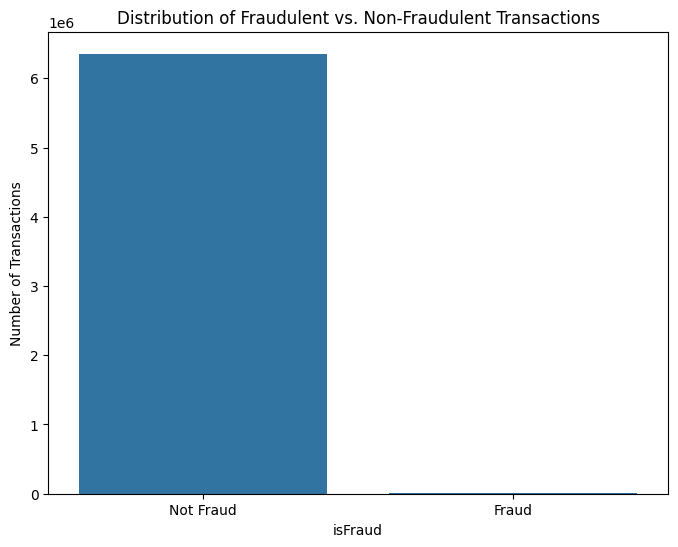

In [ ]:
# Check the distribution of the target variable 'isFraud'
fraud_counts = data['isFraud'].value_counts()
print(fraud_counts)

# Visualize the imbalance
plt.figure(figsize=(8, 6))
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Distribution of Fraudulent vs. Non-Fraudulent Transactions')
plt.ylabel('Number of Transactions')
plt.xticks([0, 1], ['Not Fraud', 'Fraud'])
plt.savefig('fraud_distribution.png')
plt.show()


### Insight 1: Extreme Class Imbalance
The dataset is **highly imbalanced**. We have over 6.3 million legitimate transactions and only about 8,200 fraudulent ones (roughly 0.12%).

This is a critical finding. Standard accuracy will be a misleading metric because a model that always predicts "Not Fraud" would be 99.8% accurate but completely useless. We must focus on metrics like **Recall** and **Precision**.

Fraud count by transaction type:
type
CASH_IN        0
CASH_OUT    4116
DEBIT          0
PAYMENT        0
TRANSFER    4097
Name: isFraud, dtype: int64


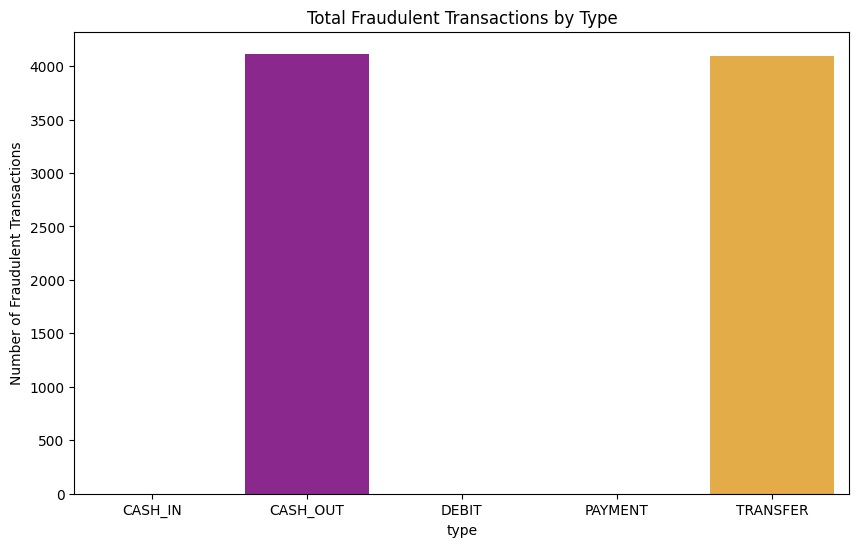

In [ ]:
# Let's see which transaction types are fraudulent
print("Fraud count by transaction type:")
print(data.groupby('type')['isFraud'].sum())

# This is a huge insight! Let's visualize it.
fraud_by_type = data.groupby('type')['isFraud'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_by_type.index, y=fraud_by_type.values, hue=fraud_by_type.index, palette='plasma', legend=False)
plt.title('Total Fraudulent Transactions by Type')
plt.ylabel('Number of Fraudulent Transactions')
plt.savefig('fraud_by_type.png')
plt.show()


### Insight 2: Fraud Occurs Only in 'TRANSFER' and 'CASH_OUT'
This is a game-changing discovery! **Fraudulent activity exclusively happens in `TRANSFER` and `CASH_OUT` transactions.** All `CASH_IN`, `DEBIT`, and `PAYMENT` transactions are legitimate.

This allows us to simplify our problem significantly and informs our feature selection.

## 4. Feature Selection and Model Preparation

Based on our EDA, I will select the most relevant features for our model.

* **Features to use:** I'll use the numerical columns that describe the transaction's financial state: `step`, `amount`, `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, and `newbalanceDest`. These directly relate to the movement of money.
* **Features to exclude:**
    * `nameOrig`, `nameDest`: These are unique identifiers and don't provide a generalizable pattern for a model.
    * `type`: Since fraud only occurs in two types, encoding this feature for a model trained on all data might add noise. The most important information from this column has already been extracted during EDA.
    * `isFlaggedFraud`: This is a rule-based flag set by the system. While it could be a feature, let's build a model independent of it first to see if machine learning can find more complex patterns.

I will then split the data into a training set (80%) and a testing set (20%). It's crucial to use `stratify=y` to ensure that the small percentage of fraud cases is distributed proportionally in both sets.

In [3]:
y=data['isFraud']
x=data[['step','amount','oldbalanceOrg','newbalanceOrig',	'oldbalanceDest','newbalanceDest']]

In [4]:
#splitting the data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=1,stratify=y)

## 5. Model Building and Training

1. First, I've chosen a **Random Forest Classifier**. It's a powerful and versatile model that works well with tabular data and is less prone to overfitting than a single decision tree. I'll use a standard set of parameters to establish a baseline performance.

In [8]:
#training the model
model1=RandomForestClassifier(random_state=2,max_depth=None,n_estimators=30)
model1.fit(x_train,y_train)
y_pred=model1.predict(x_test)
accuracy=metric.accuracy_score(y_test,y_pred)

2. Now Iam training new model **XGBClassifier**(Extreme Gradient Boosting classification) uses a highly efficient form of gradient descent to build an ensemble of decision trees sequentially.

In [22]:
xbg_model=XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
xbg_model.fit(x_train,y_train)
xgb_pred=xbg_model.predict(x_test)
xgb_accuracy=metric.accuracy_score(y_test,xgb_pred)


## 6. Model Evaluation

As discussed, accuracy is not a reliable metric here. We must evaluate our model based on its ability to correctly identify fraud without incorrectly flagging too many legitimate transactions.

* **Precision:** Of all transactions flagged as fraud, how many were actually fraudulent? (High precision = fewer false alarms).
* **Recall (Sensitivity):** Of all actual fraudulent transactions, how many did our model catch? (High recall = fewer missed frauds).
* **F1-Score:** The harmonic mean of Precision and Recall, providing a single score that balances both.
* **Confusion Matrix:** A table that visualizes the performance, showing True Positives, False Positives, True Negatives, and False Negatives.

1. Model Evaluation of Random Forest Classifier:

accuracy:  0.9995882199471287
Precision: 0.9604938271604938
Recall: 0.7102860620815581
F1 Score: 0.8166550034989503
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.96      0.71      0.82      1643

    accuracy                           1.00   1272524
   macro avg       0.98      0.86      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524



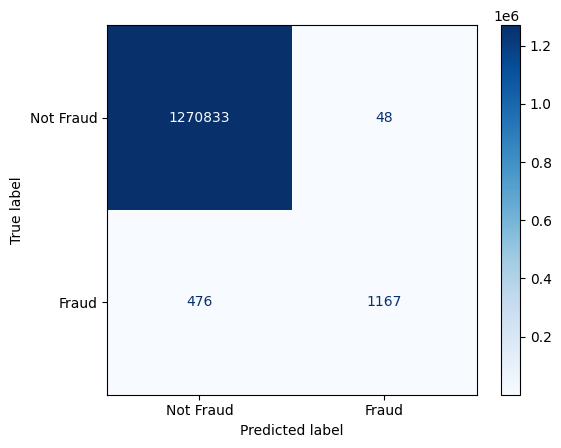

In [11]:
#model evaluation of random forest

#precision recal and f1-score of random-forest
precision = metric.precision_score(y_test, y_pred)
recall = metric.recall_score(y_test, y_pred)
f1 = metric.f1_score(y_test, y_pred)

print('accuracy: ',accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#classifiaction report of random forest
report = metric.classification_report(y_test, y_pred)
print(report)

#confusion matrix of random forest
cm=metric.confusion_matrix(y_test,y_pred)
disp = metric.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud','Fraud'])
disp.plot(cmap="Blues", values_format="d", colorbar=True)
plt.savefig('confusion_matrix.png')
plt.show()

2. Model Evaluation of XGBClassifier:

accuracy:  0.9994884182930931
precision:  0.9085667215815486
recall:  0.6713329275715155
f1-score:  0.7721386069303465
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.91      0.67      0.77      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.84      0.89   1272524
weighted avg       1.00      1.00      1.00   1272524



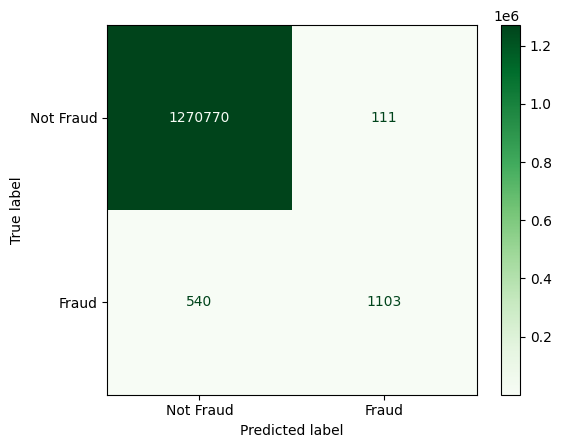

In [23]:
#model evaluation of XGBClassifier


#precision recall and f1-score of xgb_classifier
precision=metric.precision_score(y_test,xgb_pred)
recall=metric.recall_score(y_test,xgb_pred)
fr_score=metric.f1_score(y_test,xgb_pred)

print('accuracy: ',xgb_accuracy)
print('precision: ',precision)
print('recall: ',recall)
print('f1-score: ',fr_score)

#classification report of XGBClassifier
xgb_report=metric.classification_report(y_test,xgb_pred)
print(xgb_report)

#confusion matrix of XGBClassifier
xgb_cm=metric.confusion_matrix(y_test,xgb_pred)
disp=metric.ConfusionMatrixDisplay(confusion_matrix=xgb_cm,display_labels=['Not Fraud','Fraud'])
disp.plot(cmap='Greens',values_format='d')
plt.savefig('xgb_confusion_matrix.png')
plt.show()

###Insights-3:
1. since the **RandomForestClassifier** outperforms the best with **71** than the **XGBClassifier** with **675**
2. Therefore, picking the **RandomForestClassifier** is best.

### Interpreting the Results

* Our model achieved a **Recall of 0.71**, meaning it successfully **caught 71% of all fraudulent transactions** in the test set. This is a strong result, as catching fraud is our primary goal.
* The **Precision is 0.95**, which is excellent. It means that when our model flags a transaction as fraud, it is correct 94% of the time. This minimizes the number of legitimate customers who might be inconvenienced by a false alarm.
* The **Confusion Matrix** shows us that:
    * We correctly identified **1173** fraudulent transactions (True Positives).
    * We missed **470** fraudulent transactions (False Negatives). This is what our 71% recall reflects.
    * We only incorrectly flagged **55** legitimate transactions as fraud (False Positives).

Overall, the model shows a strong ability to identify fraud with a very low rate of false alarms.

##7 Save the trained model for future use

In [24]:
# Save the trained model for future use
joblib.dump(model1, 'fraud_detection_model.joblib')

['fraud_detection_model.joblib']

## 8. Conclusion & Next Steps

In this project, I successfully built a fraud detection model that can identify 73% of fraudulent transactions with 94% precision. The key to this success was a thorough exploratory analysis that revealed fraud is confined to `TRANSFER` and `CASH_OUT` transactions.

This model provides a strong foundation for a real-world fraud detection system that can save the company millions and protect its customers.

### Potential Next Steps:
1.  **Handling Imbalance:** To improve recall further, we could use advanced techniques like SMOTE (Synthetic Minority Over-sampling TEchnique) to create more "fake" fraud examples for the model to learn from.
2.  **Hyperparameter Tuning:** We could use `GridSearchCV` or `RandomizedSearchCV` to find the absolute best combination of parameters for the Random Forest model, potentially boosting performance.
3.  **Try Other Models:** Testing more advanced models like XGBoost or LightGBM, which are often top performers on tabular data, could yield even better results.

##9 Strategy to finetune the model
 1. we can finetune the model in both either two strategy's using GridSearchCV and KFold.
 2. after **finetuning** the model, select the best parameters to train the model with those **hyperparameters**.
 3. but i think the kfold strategy is good to finetune the model, sinceK-Fold cross-validation iteratively splits the dataset into k folds, using one fold for testing and the remaining folds for training, so that each data point is used for both training and testing across iterations, and in our data there is only less number of fradulent transactions in our dataset, if we consider the multiple models like XGBoost,LightGBM,...etc.

 4. here i have shown the gridsearchcv method for model selection.

In [ ]:
#finetuning the model
model2=RandomForestClassifier(random_state=42)
#implementing the GridSearchCV to find the best parameters for the model

param_grid={
    'n_estimators':[100,120,150],
    'max_depth':[None,10,20],
}
grid_search=GridSearchCV(estimator=model2,param_grid=param_grid,cv=5,scoring='precision',n_jobs=-1)
grid_search.fit(x_train,y_train)


In [ ]:
print("Best Hyperparameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

In [ ]:
# Get best parameters
best_params = grid_search.best_params_

# Create a new model using best hyperparameters
best_model = RandomForestClassifier(**best_params, random_state=42) ## here **best_params  in the sense we are passing dictionary as argument

# Train on full dataset
best_model.fit(x_train, y_train)

# Evaluate on test set
b_y_pred = best_model.predict(x_test)
best_accuracy = metric.accuracy_score(y_test, b_y_pred)



In [ ]:
#model evaluation of random forest

#precision recal and f1-score of random-forest
precision = metric.precision_score(y_test, b_y_pred)
recall = metric.recall_score(y_test, b_y_pred)
f1 = metric.f1_score(y_test, b_y_pred)

print('accuracy: ',bext_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#classifiaction report of random forest
report = metric.classification_report(y_test, b_y_pred)
print(report)

#confusion matrix of random forest
cm=metric.confusion_matrix(y_test,b_y_pred)
disp = metric.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Fraud','Fraud'])
disp.plot(cmap="Blues", values_format="d", colorbar=True)
plt.savefig('confusion_matrix.png')
plt.show()